In [61]:
%matplotlib inline

import json
import os
import glob
import boto3

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

## boto3 client 

In [2]:
client = boto3.client('s3',
                     aws_access_key_id = os.getenv('aws_access_key'),
                     aws_secret_access_key = os.getenv('aws_secret_key'),
                     )

In [3]:
bucket_list = client.list_buckets()

In [5]:
bucket_name = 'summit-demo'

In [6]:
object_list = client.list_objects_v2(Bucket = bucket_name)['Contents']

In [7]:
len(object_list) #TODO: need paginator to get > 1000 objects

1000

In [19]:
paginator = client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix='ai-sensor-v3/device')

key_list = []
for p in pages:
    for o in p['Contents']:
        key_list.append(o['Key'])

In [20]:
print(key_list[0:10])

['ai-sensor-v3/device01/2022-02-28T16:06:33.752829.json', 'ai-sensor-v3/device01/2022-02-28T16:06:33.753092.json', 'ai-sensor-v3/device01/2022-02-28T16:06:33.754278.json', 'ai-sensor-v3/device01/2022-02-28T16:06:33.754584.json', 'ai-sensor-v3/device01/2022-02-28T16:06:34.490625.json', 'ai-sensor-v3/device01/2022-02-28T16:06:34.492986.json', 'ai-sensor-v3/device01/2022-02-28T16:06:35.315408.json', 'ai-sensor-v3/device01/2022-02-28T16:06:36.039800.json', 'ai-sensor-v3/device01/2022-02-28T16:06:37.446556.json', 'ai-sensor-v3/device01/2022-02-28T16:06:37.496693.json']


In [21]:
len(key_list)

1658

## WARNING: This will start downloading data

In [22]:
data_list = []
for k in key_list:
    data = client.get_object(Bucket = bucket_name, Key = k)['Body'].readlines()
    data_list.append(data)

## Plotting

In [52]:
data = [json.loads(d[0].decode('utf-8')) for d in data_list]

In [88]:
uniq_dids = np.unique([d['deviceuid'] for d in data])
print(len(unique_dids))

5


In [62]:
data[0]

{'specversion': '1.0',
 'id': '9908c9cb-2658-44b1-9123-a0f84bf26597',
 'type': 'io.drogue.event.v1',
 'source': 'drogue://burrboard/device01',
 'datacontenttype': 'application/json',
 'subject': 'state',
 'time': '2022-02-28T16:06:33.741695136Z',
 'data': {'features': {'led_1': {'state': False}}},
 'applicationuid': '6336013e-75d0-4457-b941-8ba63f5f0597',
 'deviceuid': 'c0108d44-8980-44f8-8201-46681179b184',
 'senderuid': 'c0108d44-8980-44f8-8201-46681179b184',
 'sender': 'device01',
 'application': 'burrboard',
 'device': 'device01',
 'instance': 'drogue',
 'partitionkey': 'burrboard/device01'}

In [85]:
#number of features
#[d['data'] for d in data if len(d['data']['features'])>1] 
np.unique([len(d['data']['features']) for d in data], return_counts=True)

(array([ 1,  8, 10]), array([ 196, 1035,  427]))

In [87]:
#unique features
uniq_features = np.unique(np.concatenate([list(d['data']['features'].keys()) for d in data]))
print(uniq_features)

['accelerometer' 'button_a' 'button_b' 'device' 'led_1' 'led_2' 'led_3'
 'led_4' 'light' 'temperature']


In [102]:
[d['data']['features']['device'] for d in data if 'device' in d['data']['features']][0:10]

[{'battery': 1.0},
 {'battery': 1.0},
 {'battery': 1.0},
 {'battery': 1.0},
 {'battery': 1.0},
 {'battery': 1.0},
 {'battery': 1.0},
 {'battery': 1.0},
 {'battery': 1.0},
 {'battery': 1.0}]

In [165]:
#format data
data_ts = {}
for i in uniq_dids:
    data_ts[i] = [(d['time'], d['data']) for d in data if d['deviceuid']==i]
    
data_df = {'deviceuid': [], 'timestamp': [], 'metric': [], 'key': [], 'val': []}
for d in data: #(ts, uid)
    for m in d['data']['features']: #light, temp, accelerometer etc.
        if m=='accelerometer':
            data_df['deviceuid'].append(d['deviceuid'])
            data_df['timestamp'].append(d['time'])
    
            data_df['metric'].append(m)
            data_df['key'].append('mag')
            
            mag = np.sqrt(d['data']['features'][m]['x']**2 + d['data']['features'][m]['y']**2 + d['data']['features'][m]['z']**2)
            data_df['val'].append(mag)
            
        for v in d['data']['features'][m]: #1 val or 3 vals (acc) 
            
            data_df['deviceuid'].append(d['deviceuid'])
            data_df['timestamp'].append(d['time'])
    
            data_df['metric'].append(m)
            data_df['key'].append(v)
            data_df['val'].append(d['data']['features'][m][v])

In [166]:
df = pd.DataFrame(data_df)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['deviceuid', 'timestamp', 'metric'], inplace=True)
df.to_csv('data.csv', index=False)

In [167]:
df.head(20)

,deviceuid,timestamp,metric,key,val
13079,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.133909687+00:00,led_1,state,False
13078,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134118885+00:00,led_2,state,False
13077,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134351977+00:00,led_3,state,False
13080,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134526240+00:00,led_4,state,False
13076,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134705075+00:00,temperature,value,29.6
13081,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134902599+00:00,light,value,1024
13082,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:49.489215681+00:00,temperature,value,29.5
13083,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:49.567254872+00:00,temperature,value,29.4
13084,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:49.583385995+00:00,temperature,value,29.1
13085,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:49.600168308+00:00,temperature,value,28.6


<Figure size 1080x1080 with 0 Axes>

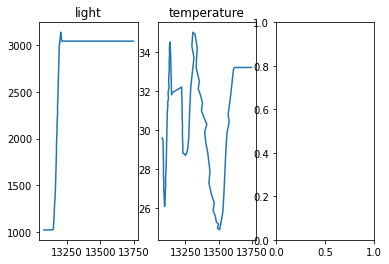

<Figure size 1080x1080 with 0 Axes>

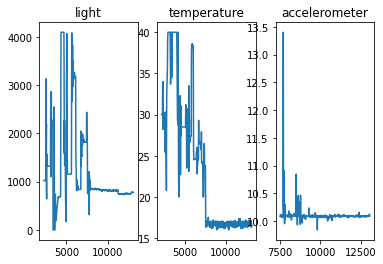

<Figure size 1080x1080 with 0 Axes>

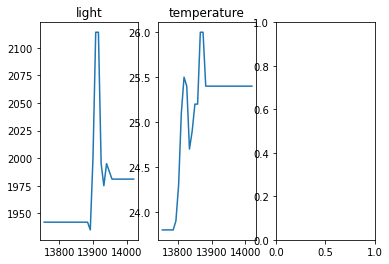

<Figure size 1080x1080 with 0 Axes>

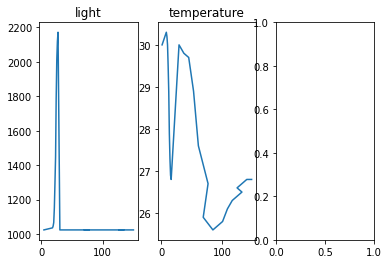

<Figure size 1080x1080 with 0 Axes>

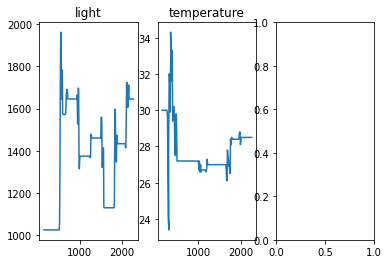

In [197]:
features = ['light', 'temperature', 'accelerometer']

for did in uniq_dids:
    plt.figure(figsize=(15,15))
    fig, ax = plt.subplots(nrows=1, ncols=len(features))
    
    for idx, m in enumerate(features):
        #plt.subplot(f'{len(features)}1{idx+1}')
        
        if m=='accelerometer':
            filtered = df[(df['deviceuid']==did) & (df['metric']==m) & (df['key']=='mag')]['val']
        else:
            filtered = df[(df['deviceuid']==did) & (df['metric']==m)]['val']
            
        if filtered.shape[0] > 0:
            ax[idx].plot(filtered)
            ax[idx].set_title(m)
        #plt.title(m)

# Synthetic data examples

In [2]:
def gen_data(mean, std, N=1000):
    '''This is not representative of time-series
    data since all samples are generated independently
    i.e. no correlations but the goal is to show simple
    strategies for scoring so it's okay
    '''
    return np.random.normal(loc=mean, scale=std, size=N)

In [3]:
N = 100

In [4]:
acc_x = gen_data(1, 0.2, N)
acc_y = gen_data(1, 0.2, N)
acc_z = gen_data(1, 0.2, N)
light = gen_data(3, 2, N)
temp = gen_data(10, 1, N)

#### Note: no units assumed in the plots below i.e. these could be some uncalibrated measurements

Text(0.5, 1.0, 'acceleration magnitude')

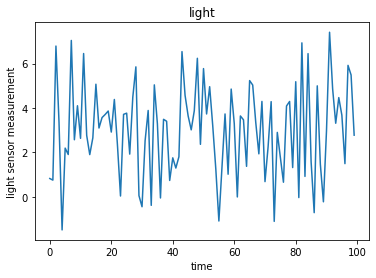

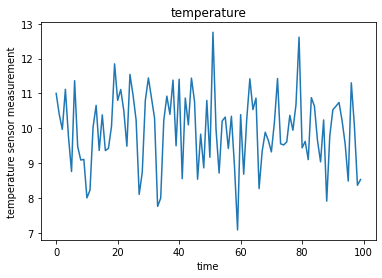

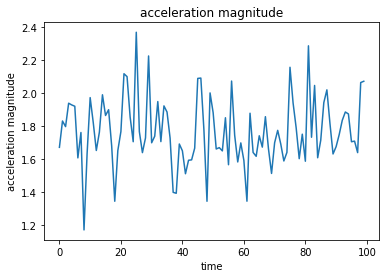

In [5]:
plt.figure()
plt.plot(light)
plt.xlabel('time')
plt.ylabel('light sensor measurement')
plt.title('light')

plt.figure()
plt.plot(temp)
plt.xlabel('time')
plt.ylabel('temperature sensor measurement')
plt.title('temperature')

plt.figure()
plt.plot(np.sqrt(acc_x**2 + acc_y**2 + acc_z**2))
plt.xlabel('time')
plt.ylabel('acceleration magnitude')
plt.title('acceleration magnitude')

### Strategy 1: make a histogram and pick percentiles (only working with light but applies to temperature and acceleration magnitude too)

{10: 0.028972425384411218, 25: 1.4860842553341411, 50: 3.2442255212895565, 75: 4.3179768506900364, 90: 5.784336515173302}


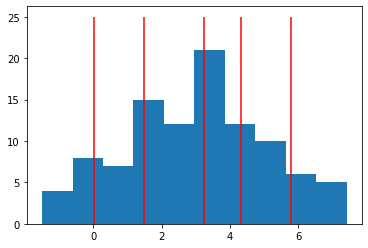

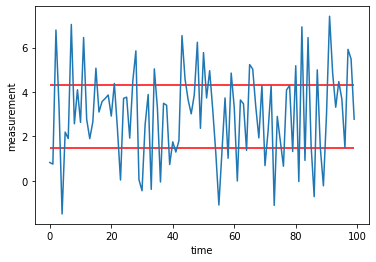

In [6]:
_ = plt.hist(light) #plot distribution of values

p_list = [10, 25, 50, 75, 90] #compute these percentiles
t = np.percentile(light, q=p_list)
mapping = dict(zip(p_list, t))

print(mapping)
#plot percentiles on histogram
for p in p_list:
    plt.vlines(mapping[p], 0, 25, color='r', label=p)
    
plt.figure()
plt.plot(light)
plt.xlabel('time')
plt.ylabel('measurement')

low_p = 25
high_p = 75
plt.hlines(mapping[low_p], 0, N-1, color='r')
plt.hlines(mapping[high_p], 0, N-1, color='r')

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5]),
 <BarContainer object of 10 artists>)

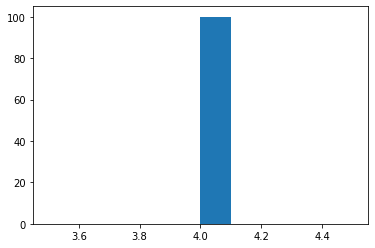

In [32]:
plt.hist(np.ones(100)*4)

### Strategy 2: ask user to perform action to get maximum light/temperature/acceleration and then scale data to range 0-1 (acceleration magnitude minimum is already 1. not sure about light/temperature sensors)

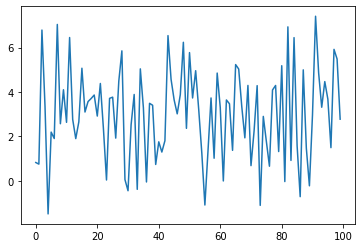

In [7]:
plt.plot(light)

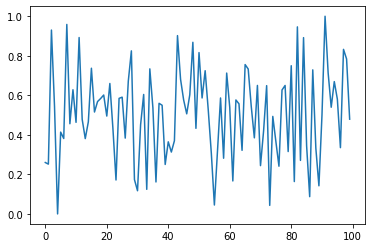

In [8]:
light_normalized = (light - light.min()) / (light.max() - light.min()) #scale to value between 0-1
plt.plot(light_normalized)

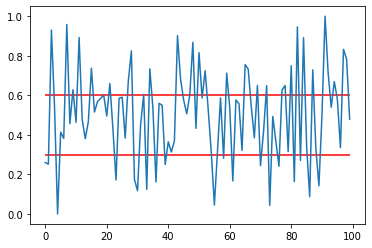

In [9]:
#these are absolute thresholds i.e. not distribution/histogram based
low_threshold = 0.3
high_threshold = 0.6
plt.plot(light_normalized)
plt.hlines(low_threshold, 0, N-1, color='r')
plt.hlines(high_threshold, 0, N-1, color='r')

# Scoring

Many options:

* score = 1 if data within range and score = 0 if data outside range

* score = 1 if data within range and score decreases (e.g. exponentially) as data falls outside



Text(0.5, 1.0, 'cumulative score')

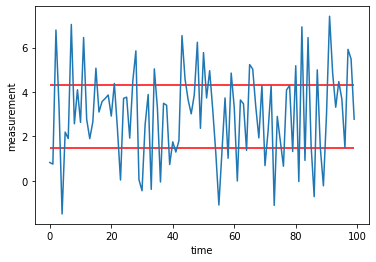

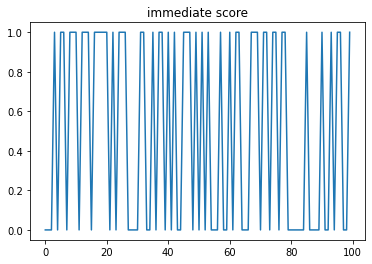

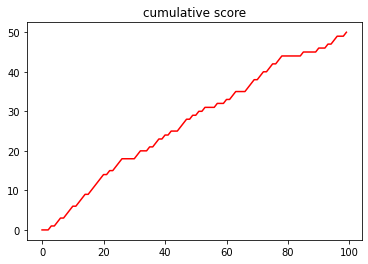

In [26]:
plt.figure()
plt.plot(light)
plt.xlabel('time')
plt.ylabel('measurement')

low_p = 25
high_p = 75
plt.hlines(mapping[low_p], 0, N-1, color='r')
plt.hlines(mapping[high_p], 0, N-1, color='r')

plt.figure()
score_1 = np.logical_and(light < mapping[high_p], light > mapping[low_p]).astype(int)
plt.plot(score_1)
plt.title('immediate score: hard thresholds')

plt.figure()
plt.plot(np.cumsum(score_1), color='r')
plt.title('cumulative score: hard thresholds')

decay_scale = 0.1
score_2 = 

np.max(light - mapping[high_p], 0)
np.max(mapping[low_p] - light, 0)

In [31]:
np.maximum(light - mapping[high_p], 0) + np.maximum(mapping[low_p] - light, 0)

array([0.66441878, 0.73693794, 2.47446893, 0.        , 2.98152343,
       0.        , 0.        , 2.72741999, 0.        , 0.        ,
       0.        , 2.13748955, 0.        , 0.        , 0.        ,
       0.75392049, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06612072, 0.        , 1.45281898, 0.        ,
       0.        , 0.        , 0.17251458, 1.53607604, 1.43440379,
       1.93691336, 0.        , 0.        , 1.87402858, 0.72482573,
       0.        , 1.54156358, 0.        , 0.        , 0.75185617,
       0.        , 0.19285855, 0.        , 2.22371943, 0.25387407,
       0.        , 0.        , 0.        , 1.92283751, 0.        ,
       1.4586134 , 0.        , 0.6425663 , 0.        , 0.23781605,
       2.5801071 , 0.16919168, 0.        , 0.47147205, 0.5355123 ,
       0.        , 1.49574752, 0.        , 0.        , 0.11582058,
       0.91821752, 0.71715481, 0.        , 0.        , 0.        ,
       0.80494315, 0.        , 0.        , 2.59666238, 0.     